In [140]:
import pandas as pd
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import plotly.offline as pyo
import plotly.subplots as sp
from plotly.subplots import make_subplots
from sklearn.model_selection import train_test_split

from statsmodels.tsa.seasonal import seasonal_decompose
import scipy.stats as stats
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler, label_binarize
from sklearn.decomposition import PCA  
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import RandomOverSampler
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler 
from sklearn.preprocessing import OrdinalEncoder, LabelEncoder
## pipelines
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules

#Modules related to classification
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC

In [2]:
## Importing Datasets
cust = pd.DataFrame(pd.read_excel(r'Datasets\CustomersData.xlsx'))
Disc = pd.DataFrame(pd.read_csv(r'Datasets\Discount_Coupon.csv'))
Mark_spent = pd.DataFrame(pd.read_csv(r'Datasets\Marketing_Spend.csv'))
sales = pd.DataFrame(pd.read_csv(r'Datasets\Online_Sales.csv'))
Tax = pd.DataFrame(pd.read_excel(r'Datasets\Tax_amount.xlsx'))

In [3]:
## Dataset "cust" does not have any null values
cust.info()
cust.nunique()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1468 entries, 0 to 1467
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   CustomerID     1468 non-null   int64 
 1   Gender         1468 non-null   object
 2   Location       1468 non-null   object
 3   Tenure_Months  1468 non-null   int64 
dtypes: int64(2), object(2)
memory usage: 46.0+ KB


CustomerID       1468
Gender              2
Location            5
Tenure_Months      49
dtype: int64

In [4]:
## Dataset "Disc" does not have any null values
Disc.info()
Disc.nunique()

Disc.rename(columns={'Product_Category ': 'Product_Category'}, inplace=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 204 entries, 0 to 203
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Month              204 non-null    object
 1   Product_Category   204 non-null    object
 2   Coupon_Code        204 non-null    object
 3   Discount_pct       204 non-null    int64 
dtypes: int64(1), object(3)
memory usage: 6.5+ KB


In [5]:
## Dataset "Mark_spent" does not have any null values
Mark_spent.info()

## converting Date column type to datetime type as it is object type
Mark_spent['Date'] = pd.to_datetime(Mark_spent['Date'], format='%m/%d/%Y')

Mark_spent.nunique()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 365 entries, 0 to 364
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Date           365 non-null    object 
 1   Offline_Spend  365 non-null    int64  
 2   Online_Spend   365 non-null    float64
dtypes: float64(1), int64(1), object(1)
memory usage: 8.7+ KB


Date             365
Offline_Spend     11
Online_Spend     365
dtype: int64

In [6]:
## Dataset "sales" does not have any null values
sales.info()

## converting Date column type to datetime type as it is object type
sales['Transaction_Date'] = pd.to_datetime(sales['Transaction_Date'], format='%Y%m%d')

sales.nunique()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52924 entries, 0 to 52923
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   CustomerID           52924 non-null  int64  
 1   Transaction_ID       52924 non-null  int64  
 2   Transaction_Date     52924 non-null  int64  
 3   Product_SKU          52924 non-null  object 
 4   Product_Description  52924 non-null  object 
 5   Product_Category     52924 non-null  object 
 6   Quantity             52924 non-null  int64  
 7   Avg_Price            52924 non-null  float64
 8   Delivery_Charges     52924 non-null  float64
 9   Coupon_Status        52924 non-null  object 
dtypes: float64(2), int64(4), object(4)
memory usage: 4.0+ MB


CustomerID              1468
Transaction_ID         25061
Transaction_Date         365
Product_SKU             1145
Product_Description      404
Product_Category          20
Quantity                 151
Avg_Price                546
Delivery_Charges         267
Coupon_Status              3
dtype: int64

In [7]:
## Dataset "Tax" does not have any null values
Tax.info()
Tax.nunique()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 2 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Product_Category  20 non-null     object 
 1   GST               20 non-null     float64
dtypes: float64(1), object(1)
memory usage: 448.0+ bytes


Product_Category    20
GST                  4
dtype: int64

In [8]:
## Function for Outlier treatment
def treat_outliers(df, lower_quantile=0.01, upper_quantile=0.99):

## This function will return the dataset after clipping at lower percentile of 1% & upper percentile of 99% by iterating over each column
    treated_df = pd.DataFrame()

    for column in df.columns:
        lower_threshold = df[column].quantile(lower_quantile)
        upper_threshold = df[column].quantile(upper_quantile)

        treated_column = df[column].clip(lower_threshold, upper_threshold)
        treated_df[column] = treated_column

    return treated_df


## Function to treat missing values
def Null_treatment(x):
    for col in x.columns:
        if x[col].dtype == 'object':
         x[col].fillna(x[col].mode()[0],inplace=True)
        else:
           x[col].fillna(x[col].median(),inplace=True)
    return(x) 

In [ ]:
## Merging sales & Cust datset
cust_1 = sales.merge(cust,on='CustomerID',how='left')

## Merging Cust1 & Tax datset
cust_2 =pd.merge(cust_1, Tax, on = "Product_Category", how="left")

## Getting the Month from Transaction Date
cust_2['tx_month'] = cust_2.Transaction_Date.dt.strftime("%b")

## Merging Cust2 & Discount dataset based on 'tx_month', 'Product_Category' & 'Month'
cust_360 =pd.merge(cust_2, Disc, left_on= ['tx_month', 'Product_Category'], right_on = ['Month', 'Product_Category'], how = "left")

## Droping the "tx_month" column
cust_360.drop("tx_month", axis= 1, inplace=True)

## Saving the desired information under cust_360
cust_360

In [10]:
## Creating Invoice Amount Column having total amount paid for a transaction.
cust_360['Invoice_Amount'] = (
    (cust_360['Quantity'] * cust_360['Avg_Price']) * (1 - (cust_360['Discount_pct']/100)) * (1 + cust_360['GST'])
) + cust_360['Delivery_Charges']

In [ ]:
## Checking the null values
cust_360.isna().sum()

In [ ]:
## Treating The Null Values
Null_treatment(cust_360)

In [13]:
## Customer accuquired Every Month
acquired_customers_per_month = cust_360.groupby(cust_360['Transaction_Date'].dt.to_period('M'))['CustomerID'].nunique().reset_index()
acquired_customers_per_month['Transaction_Date'] = acquired_customers_per_month['Transaction_Date'].astype(str)


# Plot using Plotly
fig = px.line(acquired_customers_per_month, x='Transaction_Date', y='CustomerID', title='Acquired Customers per Month')
fig.update_xaxes(title_text='Month')
fig.update_yaxes(title_text='Number of Customers')

fig.show()

In [14]:
# Counting new and total customers per month
new_cust = cust_360.groupby(cust_360['Transaction_Date'].dt.to_period('M'))['CustomerID'].nunique()
total_cust = cust_360.groupby(cust_360['Transaction_Date'].dt.to_period('M'))['CustomerID'].count()

# Creating a DataFrame
final = pd.concat([total_cust, new_cust], axis=1)
final.columns = ['Total_cust', 'New_cust']

# Calculating retained customers
final['Retained_cust'] = final['Total_cust'] - final['New_cust']

# Plotting using Plotly
fig = px.line(final, x=final.index.to_timestamp(), y=['Total_cust', 'New_cust', 'Retained_cust'], title='Customer Acquisition and Retention')
fig.update_xaxes(title_text='Date')
fig.update_yaxes(title_text='Number of Customers')

fig.show()

In [15]:
# Calculating total revenues per month
revenues_per_month = cust_360.groupby(cust_360['Transaction_Date'].dt.to_period('M'))['Invoice_Amount'].sum()

# Calculating revenues from new customers per month
new_cust_revenues = cust_360[
    cust_360['CustomerID'].duplicated(keep='first') == False].groupby(
        cust_360['Transaction_Date'].dt.to_period('M'))['Invoice_Amount'].sum()

# Calculating revenues from existing customers per month
existing_cust_revenues = revenues_per_month - new_cust_revenues

# Createing a DataFrame
revenues_df = pd.DataFrame({
    'Total_Revenues': revenues_per_month,
    'New_Customer_Revenues': new_cust_revenues,
    'Existing_Customer_Revenues': existing_cust_revenues
}).reset_index()

# Convering Periods to strings
revenues_df['Transaction_Date'] = revenues_df['Transaction_Date'].astype(str)

# Plotting using Plotly
fig = px.line(
    revenues_df,
    x='Transaction_Date',
    y=['Total_Revenues', 'New_Customer_Revenues', 'Existing_Customer_Revenues'],
    title='Revenues from Existing and New Customers',
    labels={'Transaction_Date': 'Month', 'value': 'Revenues'},
    hover_name='Transaction_Date'
)

fig.update_xaxes(type='category')  # To ensure proper sorting of months

# Customizing the layout for an enhanced appearance
fig.update_layout(
    legend=dict(title='Revenue Type'),
    xaxis_title='Month',
    yaxis_title='Revenues',
    hovermode='x unified',
    template='plotly_dark'
)

fig.show()

In [16]:
# Calculating total revenues per month
revenues_per_month = cust_360.groupby(cust_360['Transaction_Date'].dt.to_period('M'))['Invoice_Amount'].sum()

# Calculating total revenues after applying discounts per month
revenues_with_discounts = cust_360.groupby(cust_360['Transaction_Date'].dt.to_period('M')).apply(
    lambda x: (x['Invoice_Amount'] * (1 - (x['Discount_pct']/100))).sum())

# Creating a DataFrame to store discount impact
discount_impact_df = pd.DataFrame({
    'Revenues_without_Discount': revenues_per_month,
    'Revenues_with_Discount': revenues_with_discounts,
    'Discount_Impact': revenues_per_month - revenues_with_discounts
}).reset_index()

# Converting Periods to strings
discount_impact_df['Transaction_Date'] = discount_impact_df['Transaction_Date'].astype(str)

# Plotting using Plotly
fig = px.line(
    discount_impact_df,
    x='Transaction_Date',
    y=['Revenues_without_Discount', 'Revenues_with_Discount', 'Discount_Impact'],
    title='Impact of Discounts on Revenue',
    labels={'Transaction_Date': 'Month', 'value': 'Revenue'},
    hover_name='Transaction_Date'
)

# Customizing the layout for an enhanced appearance
fig.update_layout(
    legend=dict(title='Revenue Type'),
    xaxis_title='Month',
    yaxis_title='Revenue',
    hovermode='x unified',
    template='plotly_dark'
)

fig.show()

In [17]:
# Calculating revenue by category, by month, by week, and by day
revenue_by_category = cust_360.groupby('Product_Category')['Invoice_Amount'].sum().reset_index()
revenue_by_month = cust_360.groupby(cust_360['Transaction_Date'].dt.to_period('M'))['Invoice_Amount'].sum().reset_index()
revenue_by_week = cust_360.groupby(cust_360['Transaction_Date'].dt.to_period('W-MON'))['Invoice_Amount'].sum().reset_index()
revenue_by_day = cust_360.groupby(cust_360['Transaction_Date'].dt.to_period('D'))['Invoice_Amount'].sum().reset_index()

# Converting Periods to strings
revenue_by_month['Transaction_Date'] = revenue_by_month['Transaction_Date'].astype(str)
revenue_by_week['Transaction_Date'] = revenue_by_week['Transaction_Date'].astype(str)
revenue_by_day['Transaction_Date'] = revenue_by_day['Transaction_Date'].astype(str)

# Creating subplots 
fig = make_subplots(rows=2, cols=2,
                    subplot_titles=("Revenue by Category", "Revenue by Month", "Revenue by Week", "Revenue by Day"),
                    specs=[[{'rowspan': 1, 'colspan': 1}, {'rowspan': 1, 'colspan': 1}],
                           [{'rowspan': 1, 'colspan': 1}, {'rowspan': 1, 'colspan': 1}]])

# Adding traces to the subplots
fig.add_trace(go.Bar(x=revenue_by_category['Product_Category'], y=revenue_by_category['Invoice_Amount']), row=1, col=1)
fig.add_trace(go.Line(x=revenue_by_month['Transaction_Date'], y=revenue_by_month['Invoice_Amount']), row=1, col=2)
fig.add_trace(go.Line(x=revenue_by_week['Transaction_Date'], y=revenue_by_week['Invoice_Amount']), row=2, col=1)
fig.add_trace(go.Line(x=revenue_by_day['Transaction_Date'], y=revenue_by_day['Invoice_Amount']), row=2, col=2)

# Update layout for better appearance
fig.update_layout(title="Revenue Trends",
                  showlegend=False,
                  template="plotly_dark",
                  width=1000, 
                  height=800)  

# Show the plot
fig.show()

c:\Users\priya\AppData\Local\Programs\Python\Python310\lib\site-packages\plotly\graph_objs\_deprecations.py:378: DeprecationWarning:

plotly.graph_objs.Line is deprecated.
Please replace it with one of the following more specific types
  - plotly.graph_objs.scatter.Line
  - plotly.graph_objs.layout.shape.Line
  - etc.




In [18]:
# Calculating number of orders by category, by month, by week, and by day
orders_by_category = cust_360.groupby('Product_Category')['Transaction_ID'].nunique().reset_index()
orders_by_month = cust_360.groupby(cust_360['Transaction_Date'].dt.to_period('M'))['Transaction_ID'].nunique().reset_index()
orders_by_week = cust_360.groupby(cust_360['Transaction_Date'].dt.to_period('W-MON'))['Transaction_ID'].nunique().reset_index()
orders_by_day = cust_360.groupby(cust_360['Transaction_Date'].dt.to_period('D'))['Transaction_ID'].nunique().reset_index()

# Converting Periods to strings
orders_by_month['Transaction_Date'] = orders_by_month['Transaction_Date'].astype(str)
orders_by_week['Transaction_Date'] = orders_by_week['Transaction_Date'].astype(str)
orders_by_day['Transaction_Date'] = orders_by_day['Transaction_Date'].astype(str)

# Creating subplots
fig = make_subplots(rows=2, cols=2,
                    subplot_titles=("Orders by Category", "Orders by Month", "Orders by Week", "Orders by Day"),
                    specs=[[{'rowspan': 1, 'colspan': 1}, {'rowspan': 1, 'colspan': 1}],
                           [{'rowspan': 1, 'colspan': 1}, {'rowspan': 1, 'colspan': 1}]])

# Adding traces to the subplots
fig.add_trace(go.Bar(x=orders_by_category['Product_Category'], y=orders_by_category['Transaction_ID']), row=1, col=1)
fig.add_trace(go.Line(x=orders_by_month['Transaction_Date'], y=orders_by_month['Transaction_ID']), row=1, col=2)
fig.add_trace(go.Line(x=orders_by_week['Transaction_Date'], y=orders_by_week['Transaction_ID']), row=2, col=1)
fig.add_trace(go.Line(x=orders_by_day['Transaction_Date'], y=orders_by_day['Transaction_ID']), row=2, col=2)

# Update layout for better appearance
fig.update_layout(title="Number of Orders",
                  showlegend=False,
                  template="plotly_dark",
                  width=1000,  # Set the width of the entire subplot
                  height=800)  # Set the height of the entire subplot

# Show the plot
fig.show()

c:\Users\priya\AppData\Local\Programs\Python\Python310\lib\site-packages\plotly\graph_objs\_deprecations.py:378: DeprecationWarning:

plotly.graph_objs.Line is deprecated.
Please replace it with one of the following more specific types
  - plotly.graph_objs.scatter.Line
  - plotly.graph_objs.layout.shape.Line
  - etc.




In [19]:
# Calculating average order value by category, by month, by week, and by day
avg_order_value_by_category = cust_360.groupby('Product_Category')['Avg_Price'].mean().reset_index()
avg_order_value_by_month = cust_360.groupby(cust_360['Transaction_Date'].dt.to_period('M'))['Avg_Price'].mean().reset_index()
avg_order_value_by_week = cust_360.groupby(cust_360['Transaction_Date'].dt.to_period('W-MON'))['Avg_Price'].mean().reset_index()
avg_order_value_by_day = cust_360.groupby(cust_360['Transaction_Date'].dt.to_period('D'))['Avg_Price'].mean().reset_index()

# Converting Periods to strings
avg_order_value_by_month['Transaction_Date'] = avg_order_value_by_month['Transaction_Date'].astype(str)
avg_order_value_by_week['Transaction_Date'] = avg_order_value_by_week['Transaction_Date'].astype(str)
avg_order_value_by_day['Transaction_Date'] = avg_order_value_by_day['Transaction_Date'].astype(str)

# Creating subplots with increased size
fig = make_subplots(rows=2, cols=2,
                    subplot_titles=("Average Order Value by Category", "Average Order Value by Month", "Average Order Value by Week", "Average Order Value by Day"),
                    specs=[[{'rowspan': 1, 'colspan': 1}, {'rowspan': 1, 'colspan': 1}],
                           [{'rowspan': 1, 'colspan': 1}, {'rowspan': 1, 'colspan': 1}]])

# Adding traces to the subplots
fig.add_trace(go.Bar(x=avg_order_value_by_category['Product_Category'], y=avg_order_value_by_category['Avg_Price']), row=1, col=1)
fig.add_trace(go.Line(x=avg_order_value_by_month['Transaction_Date'], y=avg_order_value_by_month['Avg_Price']), row=1, col=2)
fig.add_trace(go.Line(x=avg_order_value_by_week['Transaction_Date'], y=avg_order_value_by_week['Avg_Price']), row=2, col=1)
fig.add_trace(go.Line(x=avg_order_value_by_day['Transaction_Date'], y=avg_order_value_by_day['Avg_Price']), row=2, col=2)

# Update layout for better appearance
fig.update_layout(title="Average Order Value",
                  showlegend=False,
                  template="plotly_dark",
                  width=1000,  # Set the width of the entire subplot
                  height=800)  # Set the height of the entire subplot

# Show the plot
fig.show()

c:\Users\priya\AppData\Local\Programs\Python\Python310\lib\site-packages\plotly\graph_objs\_deprecations.py:378: DeprecationWarning:

plotly.graph_objs.Line is deprecated.
Please replace it with one of the following more specific types
  - plotly.graph_objs.scatter.Line
  - plotly.graph_objs.layout.shape.Line
  - etc.




In [20]:
# Calculating quantity by category, by month, by week, and by day
quantity_by_category = cust_360.groupby('Product_Category')['Quantity'].sum().reset_index()
quantity_by_month = cust_360.groupby(cust_360['Transaction_Date'].dt.to_period('M'))['Quantity'].sum().reset_index()
quantity_by_week = cust_360.groupby(cust_360['Transaction_Date'].dt.to_period('W-MON'))['Quantity'].sum().reset_index()
quantity_by_day = cust_360.groupby(cust_360['Transaction_Date'].dt.to_period('D'))['Quantity'].sum().reset_index()

# Converting Periods to strings
quantity_by_month['Transaction_Date'] = quantity_by_month['Transaction_Date'].astype(str)
quantity_by_week['Transaction_Date'] = quantity_by_week['Transaction_Date'].astype(str)
quantity_by_day['Transaction_Date'] = quantity_by_day['Transaction_Date'].astype(str)

# Creating subplots with increased size
fig = make_subplots(rows=2, cols=2,
                    subplot_titles=("Quantity by Category", "Quantity by Month", "Quantity by Week", "Quantity by Day"),
                    specs=[[{'rowspan': 1, 'colspan': 1}, {'rowspan': 1, 'colspan': 1}],
                           [{'rowspan': 1, 'colspan': 1}, {'rowspan': 1, 'colspan': 1}]])

# Adding traces to the subplots
fig.add_trace(go.Bar(x=quantity_by_category['Product_Category'], y=quantity_by_category['Quantity']), row=1, col=1)
fig.add_trace(go.Line(x=quantity_by_month['Transaction_Date'], y=quantity_by_month['Quantity']), row=1, col=2)
fig.add_trace(go.Line(x=quantity_by_week['Transaction_Date'], y=quantity_by_week['Quantity']), row=2, col=1)
fig.add_trace(go.Line(x=quantity_by_day['Transaction_Date'], y=quantity_by_day['Quantity']), row=2, col=2)

# Update layout for better appearance
fig.update_layout(title="Quantity of Items Sold",
                  showlegend=False,
                  template="plotly_dark",
                  width=1000,  # Set the width of the entire subplot
                  height=800)  # Set the height of the entire subplot

# Show the plot
fig.show()

c:\Users\priya\AppData\Local\Programs\Python\Python310\lib\site-packages\plotly\graph_objs\_deprecations.py:378: DeprecationWarning:

plotly.graph_objs.Line is deprecated.
Please replace it with one of the following more specific types
  - plotly.graph_objs.scatter.Line
  - plotly.graph_objs.layout.shape.Line
  - etc.




In [21]:
# Calculating sales by location, by month, and by category
sales_by_location = cust_360.groupby(['Location'])['Invoice_Amount'].sum().reset_index()
sales_by_month = cust_360.groupby(cust_360['Transaction_Date'].dt.to_period('M'))['Invoice_Amount'].sum().reset_index()
sales_by_month['Transaction_Date'] = sales_by_month['Transaction_Date'].astype(str)  # Convert Period to string
sales_by_category = cust_360.groupby(['Product_Category'])['Invoice_Amount'].sum().reset_index()

# Creating subplots with increased size
fig = make_subplots(rows=3, cols=1,
                    subplot_titles=("Sales by Location", "Sales by Month", "Sales by Category"))

# Adding traces to the subplots
fig.add_trace(go.Bar(x=sales_by_location['Location'], y=sales_by_location['Invoice_Amount']), row=1, col=1)
fig.add_trace(go.Line(x=sales_by_month['Transaction_Date'], y=sales_by_month['Invoice_Amount']), row=2, col=1)
fig.add_trace(go.Bar(x=sales_by_category['Product_Category'], y=sales_by_category['Invoice_Amount']), row=3, col=1)

# Update layout for better appearance
fig.update_layout(title="Sales Trends",
                  template="plotly_dark",
                  showlegend=False,
                  width=1000,  # Set the width of the entire subplot
                  height=1200)  # Set the height of the entire subplot

# Show the plot
fig.show()

c:\Users\priya\AppData\Local\Programs\Python\Python310\lib\site-packages\plotly\graph_objs\_deprecations.py:378: DeprecationWarning:

plotly.graph_objs.Line is deprecated.
Please replace it with one of the following more specific types
  - plotly.graph_objs.scatter.Line
  - plotly.graph_objs.layout.shape.Line
  - etc.




In [22]:
# Calculate the sum of orders and sales by day
daily_orders = cust_360.groupby(cust_360['Transaction_Date'].dt.date)['Transaction_ID'].count()
daily_sales = cust_360.groupby(cust_360['Transaction_Date'].dt.date)['Invoice_Amount'].sum()

# Create a subplot
fig = make_subplots(rows=2, cols=1,
                    subplot_titles=("Number of Orders per Day", "Total Sales per Day"))

# Add traces to the subplots
fig.add_trace(go.Scatter(x=daily_orders.index, y=daily_orders, mode='lines', name='Number of Orders'), row=1, col=1)
fig.add_trace(go.Scatter(x=daily_sales.index, y=daily_sales, mode='lines', name='Total Sales'), row=2, col=1)

# Update layout for better appearance
fig.update_layout(title="Order and Sales Trends per Day",
                  template="plotly_dark",
                  showlegend=False,
                  width=1200,  # Set the width of the entire subplot
                  height=800)  # Set the height of the entire subplot

# Show the plot
fig.show()

In [23]:
Mark_spent["Total_Marketing_Spent"] = Mark_spent['Offline_Spend'] + Mark_spent['Online_Spend']

# Calculate day-wise revenue and assign it to "day_wise_spent" column
Mark_spent['Day_wise_sales'] = Mark_spent['Date'].map(
    cust_360.groupby(cust_360['Transaction_Date'].dt.date)['Invoice_Amount'].sum()
)

# Calculate day-wise revenue and assign it to "day_wise_spent" column
Mark_spent['Total_Delievery_charges'] = Mark_spent['Date'].map(
    cust_360.groupby(cust_360['Transaction_Date'].dt.date)['Delivery_Charges'].sum()
)

# Calculate day-wise revenue and assign it to "day_wise_spent" column
Mark_spent['Total_Tax_By_Day'] = Mark_spent['Date'].map(
    (cust_360['Avg_Price'] * cust_360['GST']).groupby(cust_360['Transaction_Date'].dt.date).sum()
)

In [24]:
# scatter plot using Plotly Express
fig = px.scatter(Mark_spent, x='Total_Marketing_Spent', y='Day_wise_sales',
                 title='Impact of Marketing Spending on Revenue',
                 labels={'Total_Marketing_Spent': 'Daily Marketing Spent', 'Invoice_Amount': 'Day Wise Sales'},
                 trendline='ols')  # Add a linear trendline

# Customize the layout
fig.update_layout(template="plotly_dark",  
                  showlegend=True,  
                  hovermode='closest',
                  width=1200, height=600) 

# Show the plot
fig.show()

In [25]:
# Calculate additional metrics
Mark_spent['Marketing_Percentage'] = (Mark_spent['Total_Marketing_Spent'] / Mark_spent['Day_wise_sales']) * 100
Mark_spent['Delivery_Charges_Percentage'] = (Mark_spent['Total_Delievery_charges'] / Mark_spent['Day_wise_sales']) * 100

# Calculate aggregated metrics by month
agg_metrics = Mark_spent.groupby(Mark_spent['Date'].dt.strftime('%b')).agg({
    'Day_wise_sales': 'sum',
    'Total_Marketing_Spent': 'sum',
    'Total_Tax_By_Day': 'sum',
    'Marketing_Percentage': 'mean',
    'Delivery_Charges_Percentage': 'mean'
}).reset_index()

# Create subplots
fig = make_subplots(rows=2, cols=2, subplot_titles=("Revenue and Marketing Spent", "Marketing Percentage", "Tax", "Delivery Charges Percentage"))

# Add traces to the subplots
fig.add_trace(go.Bar(x=agg_metrics['Date'], y=agg_metrics['Day_wise_sales'], name='Revenue'), row=1, col=1)
fig.add_trace(go.Bar(x=agg_metrics['Date'], y=agg_metrics['Total_Marketing_Spent'], name='Marketing Spent'), row=1, col=1)
fig.add_trace(go.Line(x=agg_metrics['Date'], y=agg_metrics['Marketing_Percentage'], name='Marketing Percentage'), row=1, col=2)
fig.add_trace(go.Bar(x=agg_metrics['Date'], y=agg_metrics['Total_Tax_By_Day'], name='Tax'), row=2, col=1)
fig.add_trace(go.Line(x=agg_metrics['Date'], y=agg_metrics['Delivery_Charges_Percentage'], name='Delivery Charges Percentage'), row=2, col=2)

# Update layout for better appearance
fig.update_layout(title_text="Monthly Revenue and Metrics",
                  template="plotly_dark",
                  showlegend=True,
                  width=1300,
                  height=700)

# Show the plot
fig.show()

c:\Users\priya\AppData\Local\Programs\Python\Python310\lib\site-packages\plotly\graph_objs\_deprecations.py:378: DeprecationWarning:

plotly.graph_objs.Line is deprecated.
Please replace it with one of the following more specific types
  - plotly.graph_objs.scatter.Line
  - plotly.graph_objs.layout.shape.Line
  - etc.




In [26]:
# Top 10 most appeared products
top_products = cust_360['Product_Description'].value_counts().nlargest(10)

# Top products and their counts
top_products_df = pd.DataFrame({'Product_Description': top_products.index, 'Count': top_products.values})

# Bar plot using Plotly Express
fig = px.bar(top_products_df, x='Product_Description', y='Count', title='Top 10 Most Appeared Products')
fig.update_xaxes(categoryorder='total descending')  # Sort x-axis categories by count descending
fig.update_layout(xaxis_title='Product Description', yaxis_title='Count', template='plotly_dark')

# Show the plot
fig.show()

In [27]:
# Calculate the total quantity for each product
product_quantity = cust_360.groupby('Product_Description')['Quantity'].sum()

# Top 10 products based on quantity
top_products_quantity = product_quantity.nlargest(10)

# Top products and their total quantity
top_products_quantity_df = pd.DataFrame({'Product_Description': top_products_quantity.index, 'Total_Quantity': top_products_quantity.values})

# Create a bar plot using Plotly Express
fig = px.bar(top_products_quantity_df, x='Product_Description', y='Total_Quantity', title='Top 10 Products by Total Quantity')
fig.update_xaxes(categoryorder='total descending') 
fig.update_layout(xaxis_title='Product Description', yaxis_title='Total Quantity', template='plotly_dark')

# Show the plot
fig.show()

In [28]:

# Calculate the recency for each customer
current_date = cust_360['Transaction_Date'].max()
customer_last_transaction_date = cust_360.groupby('CustomerID')['Transaction_Date'].max()
customer_recency = (current_date - customer_last_transaction_date).dt.days

# Calculate total number of transactions by each customer
transaction_count = cust_360.groupby('CustomerID')['Transaction_ID'].count()

# Calculate total revenue by each customer
total_revenue = cust_360.groupby('CustomerID')['Invoice_Amount'].sum()

# Calculate total quantity ordered by each customer for each product category
quantity_by_category = cust_360.pivot_table(index='CustomerID', columns='Product_Category', values='Quantity', aggfunc='sum', fill_value=0)

# Calculate count of coupon usage by each customer
coupon_status_count = cust_360.groupby(['CustomerID', 'Coupon_Status'])['Transaction_ID'].count().unstack(fill_value=0)

# Group by CustomerID and get the first value for other non-numeric columns
customer_info = cust_360.groupby('CustomerID').first()[['Gender', 'Location', 'Tenure_Months']]

# Merge all calculated metrics into a single DataFrame
customer_metrics = pd.concat([transaction_count, total_revenue, quantity_by_category, coupon_status_count, customer_info], axis=1)

# Rename columns for clarity
customer_metrics.rename(columns={'Transaction_ID': 'Total_Transactions', 'Invoice_Amount': 'Total_Revenue'}, inplace=True)

# Add the recency column
customer_metrics['Recency'] = customer_recency

# Reset index to have CustomerID as a column
customer_metrics.reset_index(inplace=True)


# Display the resulting DataFrame
cust_data = customer_metrics.set_index("CustomerID")


In [29]:
# Create a LabelEncoder instance
label_encoder = LabelEncoder()

# Apply LabelEncoder to each object-type column in the DataFrame
categorical_cols = cust_data.select_dtypes(include='object').columns
for col in categorical_cols:
    cust_data[col] = label_encoder.fit_transform(cust_data[col])

In [30]:
cust_data.describe()

,Total_Transactions,Total_Revenue,Accessories,Android,Apparel,Backpacks,Bags,Bottles,Drinkware,Fun,...,Notebooks & Journals,Office,Waze,Clicked,Not Used,Used,Gender,Location,Tenure_Months,Recency
count,1468.000000,1468.000000,1468.000000,1468.000000,1468.000000,1468.000000,1468.000000,1468.000000,1468.000000,1468.000000,...,1468.000000,1468.000000,1468.000000,1468.000000,1468.000000,1468.000000,1468.000000,1468.000000,1468.000000,1468.000000
mean,36.051771,3197.435773,0.747275,0.030654,22.096730,0.076975,10.403951,1.423706,20.777248,0.568120,...,6.509537,60.206403,0.779292,18.341962,5.513624,12.196185,0.363760,1.380109,25.912125,144.292234
std,50.885680,5109.282846,6.953700,0.183914,53.508788,0.477369,43.394588,6.895384,62.413786,5.782951,...,45.423951,134.580984,5.100790,25.673084,8.134550,17.758808,0.481245,1.271549,13.959667,101.936959
min,1.000000,6.990000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000
25%,10.000000,671.552228,0.000000,0.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,1.000000,0.000000,5.000000,1.000000,3.000000,0.000000,0.000000,14.000000,55.000000
50%,21.000000,1770.545200,0.000000,0.000000,9.000000,0.000000,0.000000,0.000000,2.000000,0.000000,...,0.000000,10.000000,0.000000,11.000000,3.000000,7.000000,0.000000,1.000000,26.000000,131.000000
75%,46.000000,3931.475670,0.000000,0.000000,23.000000,0.000000,4.000000,0.000000,15.000000,0.000000,...,1.000000,60.000000,0.000000,24.000000,7.000000,16.000000,1.000000,3.000000,38.000000,220.000000
max,695.000000,76716.409230,197.000000,2.000000,907.000000,12.000000,912.000000,100.000000,1082.000000,150.000000,...,1015.000000,1489.000000,178.000000,328.000000,115.000000,252.000000,1.000000,4.000000,50.000000,364.000000


### Customer Segmentation by Heuristic Method

In [31]:

# Define segmentation criteria
recency_thresholds = [55, 130, 220]
frequency_thresholds = [30, 60, 90] 
monetary_thresholds = [1000, 10000, 20000]

# Assign segments based on criteria
def assign_segment(row):
    if row['Recency'] <= recency_thresholds[0]:
        recency_segment = 'Premium'
    elif row['Recency'] <= recency_thresholds[1]:
        recency_segment = 'Gold'
    elif row['Recency'] <= recency_thresholds[2]:
        recency_segment = 'Silver'
    else:
        recency_segment = 'Standard'
    
    if row['Total_Transactions'] >= frequency_thresholds[2]:
        frequency_segment = 'Premium'
    elif row['Total_Transactions'] >= frequency_thresholds[1]:
        frequency_segment = 'Gold'
    elif row['Total_Transactions'] >= frequency_thresholds[0]:
        frequency_segment = 'Silver'
    else:
        frequency_segment = 'Standard'
    
    if row['Total_Revenue'] >= monetary_thresholds[2]:
        monetary_segment = 'Premium'
    elif row['Total_Revenue'] >= monetary_thresholds[1]:
        monetary_segment = 'Gold'
    elif row['Total_Revenue'] >= monetary_thresholds[0]:
        monetary_segment = 'Silver'
    else:
        monetary_segment = 'Standard'
    
    # Return the most frequent segment among the three criteria
    return max(set([recency_segment, frequency_segment, monetary_segment]),
    key = ([recency_segment, frequency_segment, monetary_segment]).count)


In [32]:
## Applying Segmentation on the datset
cust_data['Segment'] = cust_data.apply(assign_segment, axis=1)

In [33]:
## Saving the segmented data
Hueristic_seg = cust_data.copy()
Hueristic_seg = pd.DataFrame(Hueristic_seg)

## Saving the segmented data to Excel file
excel_filename = "Hueristic_seg.xlsx"
Hueristic_seg.to_excel(excel_filename, index=True)

### Customer Segmentation By Scientific Method

In [34]:
## Prepping the dataset for Scientif segmentation Approach
sci_seg = cust_data.drop('Segment', axis=1)

In [35]:
# Standardize the data using StandardScaler
scaler = StandardScaler()
scaled_data = scaler.fit_transform(sci_seg)

# Convert the scaled data back to a DataFrame
scaled_df = pd.DataFrame(scaled_data, columns=sci_seg.columns)

scaled_df

,Total_Transactions,Total_Revenue,Accessories,Android,Apparel,Backpacks,Bags,Bottles,Drinkware,Fun,...,Notebooks & Journals,Office,Waze,Clicked,Not Used,Used,Gender,Location,Tenure_Months,Recency
0,-0.669410,-0.591763,-0.107501,-0.166732,-0.394401,-0.161304,-0.239834,-0.206543,-0.333009,-0.098274,...,-0.143355,-0.432648,-0.152831,-0.714687,-0.678034,-0.574344,-0.756131,1.274385,0.364594,-0.365961
1,0.470788,1.742996,0.036356,-0.166732,3.905423,-0.161304,-0.101521,-0.206543,-0.220816,-0.098274,...,-0.143355,-0.038699,-0.152831,0.298392,1.043606,0.439583,1.322522,1.274385,-0.423659,-0.837001
2,-0.256579,-0.331962,-0.107501,-0.166732,-0.338316,-0.161304,1.166350,-0.206543,0.885086,-0.098274,...,-0.143355,-0.046132,-0.152831,-0.286076,-0.555060,-0.067380,1.322522,-1.085746,0.937869,-0.699614
3,-0.374531,-0.394264,-0.107501,-0.166732,-0.207452,-0.161304,-0.239834,-0.206543,-0.333009,-0.098274,...,-0.143355,-0.447514,-0.152831,-0.402970,-0.309111,-0.349027,1.322522,-1.085746,-0.065362,-1.249160
4,-0.001018,-0.282716,-0.107501,-0.166732,-0.057893,-0.161304,-0.216782,-0.206543,-0.284926,-0.098274,...,-0.143355,-0.291421,-0.152831,-0.052289,0.305760,-0.067380,-0.756131,-0.299036,0.364594,-0.365961
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1463,-0.571117,-0.463549,-0.107501,-0.166732,-0.151367,-0.161304,-0.239834,-0.206543,-0.316981,-0.098274,...,0.517314,-0.447514,-0.152831,-0.597793,-0.555060,-0.518014,-0.756131,-1.085746,-1.498549,1.233611
1464,0.077617,-0.114164,0.180214,-0.166732,-0.001808,-0.161304,-0.170677,-0.061469,-0.268898,2.150479,...,0.517314,-0.098163,0.435514,0.103569,-0.309111,0.214266,1.322522,1.274385,1.224506,-0.562227
1465,-0.551458,-0.595546,-0.107501,-0.166732,-0.263537,-0.161304,-0.239834,-0.206543,-0.333009,-0.098274,...,-0.143355,-0.432648,-0.152831,-0.558828,-0.555060,-0.518014,1.322522,-0.299036,-0.065362,0.487799
1466,-0.689068,-0.567086,-0.107501,-0.166732,-0.413096,-0.161304,-0.239834,-0.206543,-0.333009,-0.098274,...,-0.143355,-0.447514,-0.152831,-0.714687,-0.555060,-0.687002,-0.756131,-0.299036,1.511144,-0.738867


In [36]:
# Calculate the correlation matrix
correlation_matrix = scaled_df.corr()

# Create a heatmap using Plotly with text annotations
heatmap = go.Heatmap(z=correlation_matrix.values,
                     x=correlation_matrix.index,
                     y=correlation_matrix.columns,
                     colorscale='Viridis',
                     text=correlation_matrix.round(2), # Adding correlation values as text
                     hoverinfo='text')

# Set layout options for an interactive and attractive heatmap
layout = go.Layout(title="Correlation Heatmap with Annotations",
                   xaxis=dict(title="Features"),
                   yaxis=dict(title="Features"),
                   margin=dict(l=100, r=100, t=50, b=50),
                   coloraxis_colorbar=dict(title="Correlation"),
                   width=1200, 
                   height=1000  
                   )

# Create a figure with the heatmap and layout
fig = go.Figure(data=[heatmap], layout=layout)

# Display the interactive heatmap
pyo.iplot(fig)

In [37]:
# Define the correlation threshold
correlation_threshold = 0.9

# Create a mask to identify highly correlated columns
mask = correlation_matrix.abs() > correlation_threshold

# Iterate through columns and identify pairs of highly correlated columns
columns_to_remove = set()
for col in correlation_matrix.columns:
    correlated_columns = correlation_matrix.index[mask[col]]
    for correlated_col in correlated_columns:
        if correlated_col != col:
            columns_to_remove.add(correlated_col)

# Print the list of removed columns
print("columns:", columns_to_remove)

columns: {'Not Used', 'Nest-USA', 'Used', 'Total_Revenue', 'Total_Transactions', 'Clicked'}


In [38]:
## List of columns to drop
col_to_drop = [
    'Total_Transactions','Used', 'Not Used', 'Clicked', 'Nest-USA','Office', 'Waze',
    'More Bags', 'Nest', 'Nest-Canada', 'Nest-USA', 'Notebooks & Journals',
    'Apparel', 'Backpacks', 'Bags', 'Bottles', 'Drinkware', 'Fun',
    'Gift Cards', 'Google', 'Headgear', 'Housewares', 'Lifestyle', 'Accessories', 'Android',
    ]

## Dropping the desired columns
fin_data = scaled_df.drop(col_to_drop,axis =1)
fin_data

,Total_Revenue,Gender,Location,Tenure_Months,Recency
0,-0.591763,-0.756131,1.274385,0.364594,-0.365961
1,1.742996,1.322522,1.274385,-0.423659,-0.837001
2,-0.331962,1.322522,-1.085746,0.937869,-0.699614
3,-0.394264,1.322522,-1.085746,-0.065362,-1.249160
4,-0.282716,-0.756131,-0.299036,0.364594,-0.365961
...,...,...,...,...,...
1463,-0.463549,-0.756131,-1.085746,-1.498549,1.233611
1464,-0.114164,1.322522,1.274385,1.224506,-0.562227
1465,-0.595546,1.322522,-0.299036,-0.065362,0.487799
1466,-0.567086,-0.756131,-0.299036,1.511144,-0.738867


In [39]:
# Apply PCA with the desired number of components
n_components = 5
pca_model = PCA(n_components=n_components)
pca_model.fit(fin_data)

# Explained variance and cumulative explained variance ratio
explained_variance = pca_model.explained_variance_
explained_variance_ratio = pca_model.explained_variance_ratio_
cumulative_explained_variance_ratio = np.cumsum(explained_variance_ratio)

# Print the results
print("Explained Variance by Component:")
print(explained_variance)

print("\nExplained Variance Ratio by Component:")
print(explained_variance_ratio)

print("\nCumulative Explained Variance Ratio:")
print(cumulative_explained_variance_ratio)

Explained Variance by Component:
[1.19403558 1.02837919 1.01284835 0.96615414 0.80199106]

Explained Variance Ratio by Component:
[0.23864444 0.20553573 0.20243168 0.1930992  0.16028895]

Cumulative Explained Variance Ratio:
[0.23864444 0.44418017 0.64661185 0.83971105 1.        ]


In [40]:
## Geeting Desired component with reduced Dimensionality 
pca_model = PCA(n_components = 4)
pca_model = pca_model.fit(fin_data)

PC_Data = pd.DataFrame(pca_model.transform(fin_data),columns = ['PC'+str(i) for i in range(1,5)])

In [41]:
PC_Data

,PC1,PC2,PC3,PC4
0,-0.174044,-0.696272,-0.593251,1.299385
1,2.015083,-0.123960,-1.545825,-0.375932
2,0.318116,1.661164,-0.069970,-0.717834
3,0.683224,0.818018,-0.045241,-1.328159
4,-0.037723,-0.033286,0.654436,0.553636
...,...,...,...,...
1463,-1.293489,-0.973815,1.281310,-1.067059
1464,0.487403,0.976028,-1.856144,0.595365
1465,-0.642935,0.691855,-0.683766,-1.028208
1466,0.002344,0.771159,0.581411,1.281998


In [42]:
## Below Function Performs Clustering for the range provided & will provide SC score
def perform_kmeans_clustering(data, cluster_range):
    results = []

    for k in cluster_range:
        model = KMeans(n_clusters=k,n_init=10).fit(data)
        silhouette_avg = silhouette_score(data, labels=model.labels_)
        segment_distribution = pd.Series(model.labels_).value_counts() / pd.Series(model.labels_).value_counts().sum()

        result = {
            'Cluster_Solution': k,
            'Silhouette_Score': silhouette_avg,
            'Segment_Distribution': segment_distribution
        }
        results.append(result)

        print("Cluster solution:", k)
        print("Silhouette Score:", silhouette_avg)
        print("Segment Distribution:")
        print(segment_distribution)
        print("-------------------------------------------------")

    return results


In [43]:
cluster_range = [3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
results = perform_kmeans_clustering(PC_Data, cluster_range)

Cluster solution: 3
Silhouette Score: 0.2592591619675102
Segment Distribution:
0    0.399183
1    0.363760
2    0.237057
dtype: float64
-------------------------------------------------
Cluster solution: 4
Silhouette Score: 0.24031280901286733
Segment Distribution:
3    0.361035
0    0.224114
2    0.222071
1    0.192779
dtype: float64
-------------------------------------------------
Cluster solution: 5
Silhouette Score: 0.24453017549967423
Segment Distribution:
2    0.253406
3    0.250000
4    0.228202
1    0.223433
0    0.044959
dtype: float64
-------------------------------------------------
Cluster solution: 6
Silhouette Score: 0.2800828127056348
Segment Distribution:
3    0.222752
4    0.219346
0    0.208447
5    0.189373
2    0.125341
1    0.034741
dtype: float64
-------------------------------------------------
Cluster solution: 7
Silhouette Score: 0.28044543023902185
Segment Distribution:
1    0.228883
0    0.200272
3    0.191417
5    0.126703
6    0.124659
2    0.111035
4    0

In [44]:
# Disabling FutureWarnings temporarily
with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=FutureWarning)

    cluster_range = range(1, 14)
    cluster_errors = []

    for num_clusters in cluster_range:
        clusters = KMeans(n_clusters=num_clusters)
        clusters.fit(PC_Data)
        cluster_errors.append(clusters.inertia_)

# Create a DataFrame to store cluster errors
clusters_df = pd.DataFrame({"num_clusters": cluster_range, "cluster_errors": cluster_errors})


# Create an interactive line plot using Plotly
fig = px.line(
    clusters_df,
    x="num_clusters",
    y="cluster_errors",
    title="Elbow Method for Optimal Number of Clusters",
    labels={"num_clusters": "Number of Clusters", "cluster_errors": "Cluster Errors"},
    template="plotly",
)

fig.update_traces(marker=dict(size=10, color="dodgerblue"))

# Add vertical line to indicate the elbow point
fig.add_vline(x=4, line_dash="dash", line_color="red", annotation_text="Elbow Point (4 clusters)")

# Customize layout
fig.update_layout(
    xaxis=dict(ticks="outside", tickvals=list(cluster_range)),
    yaxis=dict(title="Cluster Errors"),
    title=dict(x=0.5, y=0.95),
    margin=dict(l=50, r=50, b=50, t=80),
)

fig.show()

In [45]:
## Fitting the shortlisted clusters on the data
KM_3 = KMeans(n_clusters=3, n_init=10).fit(PC_Data)
KM_4 = KMeans(n_clusters=4, n_init=10).fit(PC_Data)
KM_5 = KMeans(n_clusters=5, n_init=10).fit(PC_Data)

In [46]:
#Shortlisted solutions: K=3, K=4, K=5
cust_data['KM_3'] = KM_3.labels_ 
cust_data['KM_4'] = KM_4.labels_ 
cust_data['KM_5'] = KM_5.labels_ 

In [47]:
Kmeans_seg = cust_data.drop('Segment', axis=1)

In [48]:
## Aggregating the data by clusters & saving it as "Cust_Profile" in CSV Format
agg_by_cluster = pd.concat([Kmeans_seg.apply(np.mean),
           Kmeans_seg.groupby('KM_3').apply(np.mean).T, 
           Kmeans_seg.groupby('KM_4').apply(np.mean).T, 
           Kmeans_seg.groupby('KM_5').apply(np.mean).T
          ],axis=1)

seg_dist = pd.concat([pd.Series(Kmeans_seg.KM_3.count())/Kmeans_seg.KM_3.count(),
           Kmeans_seg.KM_3.value_counts().sort_index()/sum(Kmeans_seg.KM_3.value_counts()),
           Kmeans_seg.KM_4.value_counts().sort_index()/sum(Kmeans_seg.KM_4.value_counts()),
           Kmeans_seg.KM_5.value_counts().sort_index()/sum(Kmeans_seg.KM_5.value_counts())
])

cust_profile = pd.concat([pd.DataFrame(seg_dist).T, agg_by_cluster],axis=0)

cust_profile.columns = ["overall", 
                   "KM3_1", 'KM3_2', "KM3_3",
                   "KM4_1", 'KM4_2', "KM4_3","KM4_4",
                   "KM5_1", 'KM5_2', "KM5_3","KM5_4","KM5_5"
]

cust_profile.to_csv('Cust_profile.csv')

### Classification Model Predicting Customer Lifetime Value (LTV)

In [49]:
drop_list = ['Segment','KM_3','KM_4','KM_5']
LTV_data = cust_data.drop(drop_list, axis=1)

In [50]:
# Calculate the median revenue to determine the cutoffs for categorization
median_revenue = LTV_data['Total_Revenue'].median()

# Function to categorize revenue into three categories
def categorize_revenue(revenue):
    if revenue <= median_revenue:
        return 'Low Value'
    elif revenue > median_revenue * 2:
        return 'High Value'
    else:
        return 'Medium Value'

# Apply the function to create the dependent variable 'Revenue_Category'
LTV_data['Revenue_Category'] = LTV_data['Total_Revenue'].apply(categorize_revenue)


In [51]:
## Dividing the data into dependent & independent variable 

x = LTV_data.drop('Revenue_Category',axis=1)

y = LTV_data['Revenue_Category']

In [52]:
## Function for Outlier treatment
def treat_outliers(df, lower_quantile=0.01, upper_quantile=0.99):

## This function will return the dataset after clipping at lower percentile of 1% & upper percentile of 99% by iterating over each column
    treated_df = pd.DataFrame()

    for column in df.columns:
        lower_threshold = df[column].quantile(lower_quantile)
        upper_threshold = df[column].quantile(upper_quantile)

        treated_column = df[column].clip(lower_threshold, upper_threshold)
        treated_df[column] = treated_column

    return treated_df

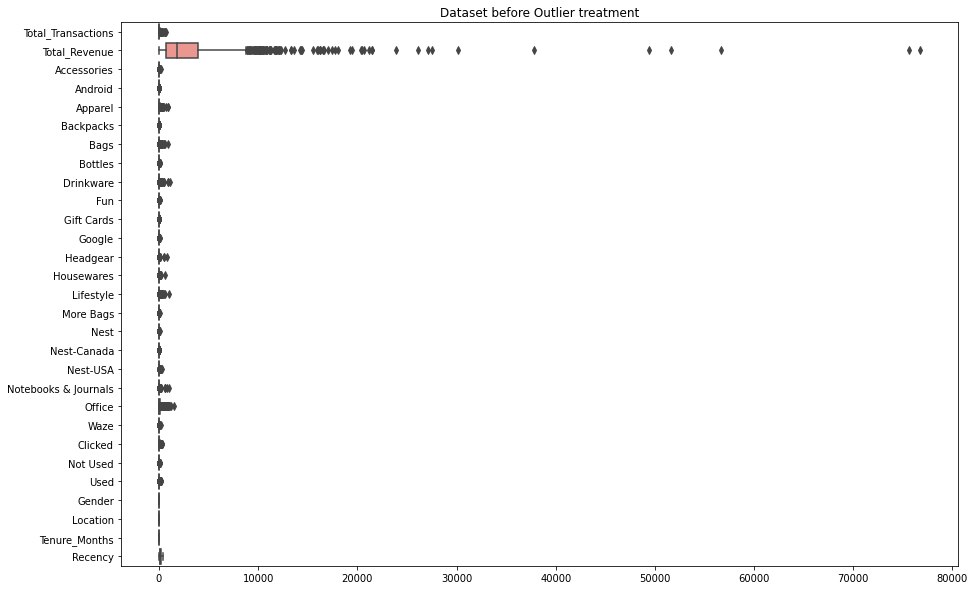

In [53]:
## Checking for outliers by Boxplot
plt.figure(figsize=(15,10))
sns.boxplot(data=x,orient="h")
plt.title("Dataset before Outlier treatment")
plt.show()

## Treating the outliers
X = treat_outliers(x)


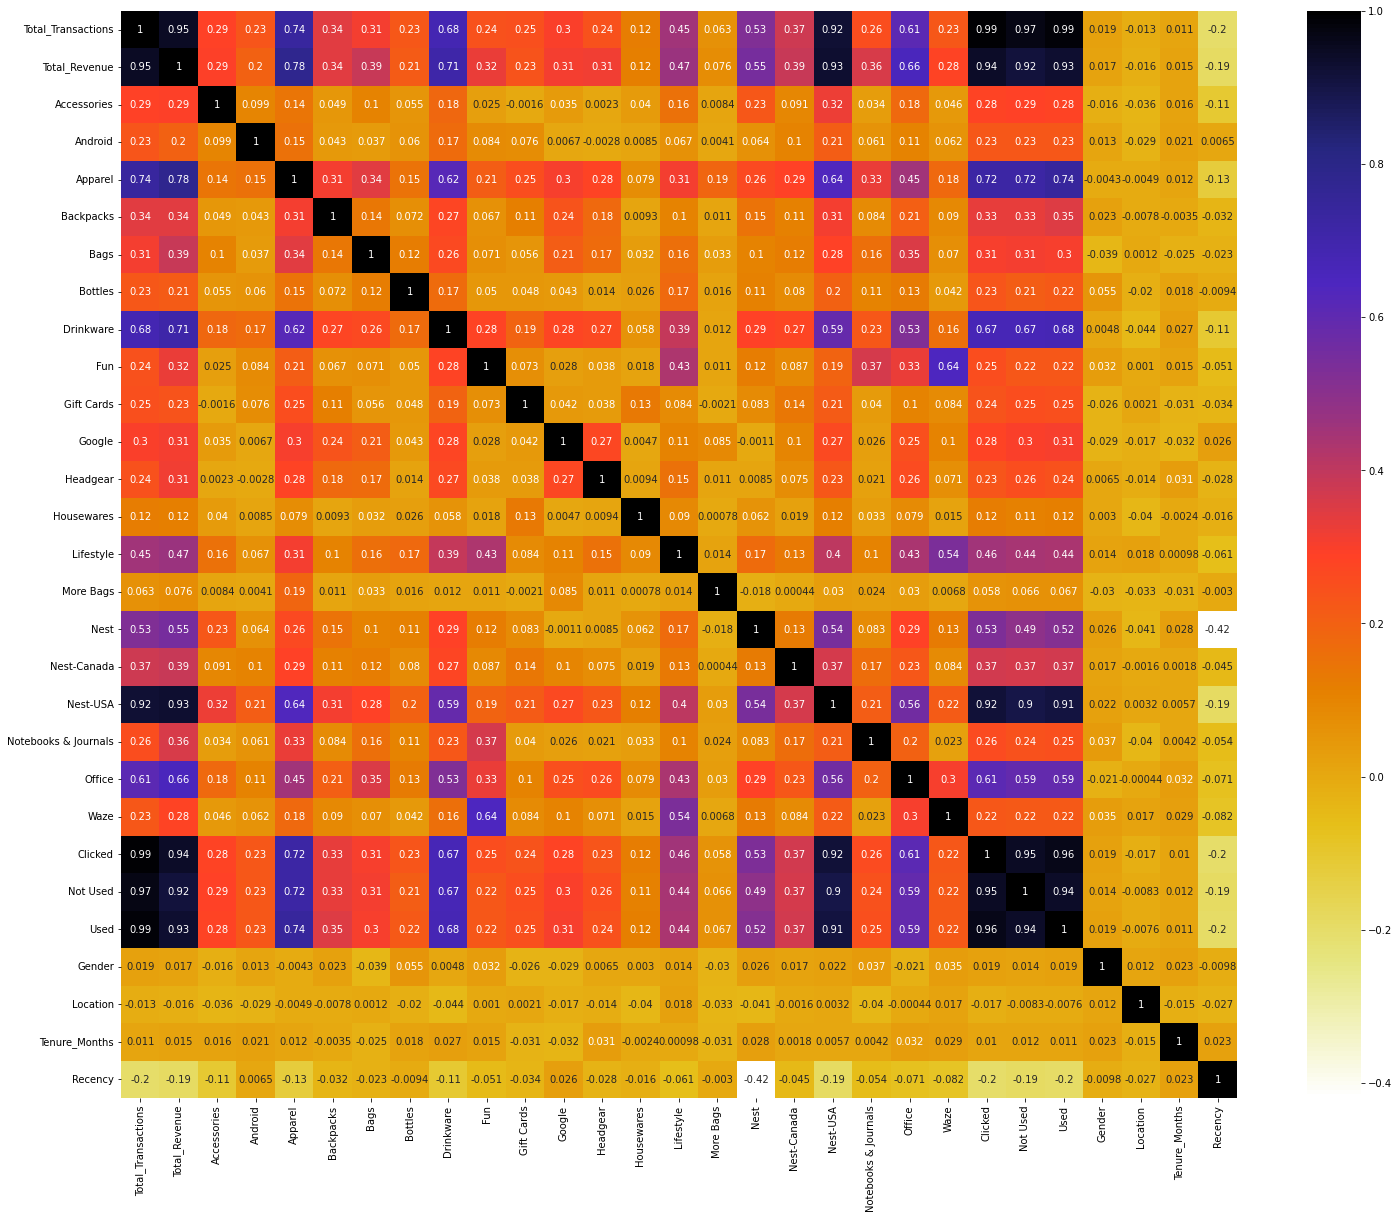

In [54]:
## Creating a correlation plot to check multicolinearity
plt.figure(figsize=(25,20))
sns.heatmap(data=x.corr(),annot=True, cmap=plt.cm.CMRmap_r)
plt.show()

In [55]:
Highly_corr_col = ['Total_Transactions', 'Nest-USA', 'Clicked', 'Not Used', 'Used']
X = x.drop(Highly_corr_col,axis=1)

In [56]:
## Splitting the dataset into train & test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"train set: {X_train.shape, y_train.shape}")
print(f"test set: {X_test.shape, y_test.shape}")

train set: ((1174, 24), (1174,))
test set: ((294, 24), (294,))


In [57]:
## As we can see it is a imbalanced dataset
y_train.value_counts()

Low Value       591
High Value      326
Medium Value    257
Name: Revenue_Category, dtype: int64

In [58]:
## Initializing resampling technique SMOTE under resampler
resampler = SMOTE(random_state = 42)
X_train_res, y_train_res = resampler.fit_resample(X_train,y_train)

In [59]:
## Data is perfectly Balanced now !
y_train_res.value_counts()

Low Value       591
High Value      591
Medium Value    591
Name: Revenue_Category, dtype: int64

In [60]:
# Define the column names
numerical_cols = list(X_train_res.columns)


# Create the preprocessing steps for numerical columns
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')), ## imputing missing values if found any
    ('scaler', StandardScaler()) ## scalung up the data using standard scaler
])



# Create the column transformer
preprocessor_X = ColumnTransformer(transformers=[
    ('num', numerical_transformer, numerical_cols)
])



# Apply the preprocessing pipeline to Train_X and Test_X
X_train_sc = pd.DataFrame(preprocessor_X.fit_transform(X_train_res),columns=preprocessor_X.get_feature_names_out())
X_test_sc = pd.DataFrame(preprocessor_X.transform(X_test),columns=preprocessor_X.get_feature_names_out())

In [61]:
encoder = OrdinalEncoder(categories=[['Low Value', 'Medium Value', 'High Value']])

# Apply encoding to y_train_res and y_test
y_train_sc = encoder.fit_transform(y_train_res.values.reshape(-1, 1))
y_test_sc = encoder.transform(y_test.values.reshape(-1, 1))

# Convert the encoded arrays back to Series
y_train_sc = pd.Series(y_train_sc.reshape(-1))
y_test_sc = pd.Series(y_test_sc.reshape(-1))

In [62]:
## Below Functions fits the model train dataset & will predict the outcome, Checking accuracy for Train & Test predicted values
def evaluate_models(x_train, y_train, x_test, y_test, models):
    results = {}

    for model_name, model in models.items():
        model.fit(x_train, y_train)

        # Make predictions on test and train data
        y_pred_test = model.predict(x_test)
        y_pred_train = model.predict(x_train)

        # Calculate accuracy for test and train data
        accuracy_test = accuracy_score(y_test, y_pred_test)
        accuracy_train = accuracy_score(y_train, y_pred_train)

        results[model_name] = {
            'test_accuracy': accuracy_test,
            'train_accuracy': accuracy_train,
            'classification_report_train': classification_report(y_train, y_pred_train),
            'classification_report_test': classification_report(y_test, y_pred_test)
        }
        
    return results

In [63]:
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'Decision Tree': DecisionTreeClassifier(),
    'Random Forest': RandomForestClassifier(random_state=42),
    'XGBoost': XGBClassifier(),
    'SVM': SVC()
}

#### Testing model & finding the best model

In [64]:
results = evaluate_models(X_train_sc,y_train_sc,X_test_sc,y_test_sc,models)

# Print the results
for model_name, metrics in results.items():
    print(f"Model: {model_name}")
    print(f"Train Accuracy: {metrics['train_accuracy']:.4f}")
    print(f"Test Accuracy: {metrics['test_accuracy']:.4f}")
    print("Classification Report Train:")
    print(metrics['classification_report_train'])
    print("Classification Report Test:")
    print(metrics['classification_report_test'])
    print("=" * 50)

Model: Logistic Regression
Train Accuracy: 0.9543
Test Accuracy: 0.9354
Classification Report Train:
              precision    recall  f1-score   support

         0.0       0.98      0.94      0.96       591
         1.0       0.89      0.98      0.93       591
         2.0       1.00      0.94      0.97       591

    accuracy                           0.95      1773
   macro avg       0.96      0.95      0.95      1773
weighted avg       0.96      0.95      0.95      1773

Classification Report Test:
              precision    recall  f1-score   support

         0.0       0.96      0.95      0.96       143
         1.0       0.84      0.90      0.87        70
         2.0       0.97      0.94      0.96        81

    accuracy                           0.94       294
   macro avg       0.93      0.93      0.93       294
weighted avg       0.94      0.94      0.94       294

Model: Decision Tree
Train Accuracy: 1.0000
Test Accuracy: 1.0000
Classification Report Train:
              

In [65]:
# Initializing XGBoost model
XGB_class = XGBClassifier()

# Training the model
XGB_class.fit(X_train_sc, y_train_sc)

# Predicting for Train & Test dataset
train_pred_XGB = XGB_class.predict(X_train_sc)
test_pred_XGB = XGB_class.predict(X_test_sc)

In [ ]:
import pickle

## Setting up the path
path = "A:\Analytix\Machine learning\ML projects\Finding-Marketing-Insights\Cust_LTV_Model.pkl"

# saving best model into a picke file
with open(path, 'wb') as f:
    pickle.dump(XGB_class, f)

### Classification Model Predicting Next Purchase Day

In [67]:
# Calculate total number of transactions by each customer
transaction_count = cust_360.groupby('CustomerID')['Transaction_ID'].count()

# Filter customers with more than 1 transaction
repeat_customers = transaction_count[transaction_count > 1].index

# Filter dataset for repeat customers
repeat_customers_data = cust_360[cust_360['CustomerID'].isin(repeat_customers)]

# Sort data by CustomerID and Transaction_Date
repeat_customers_data.sort_values(by=['CustomerID', 'Transaction_Date'], inplace=True)

# Calculate time differences between consecutive transactions for each repeat customer
repeat_customers_data['Transaction_Date'] = pd.to_datetime(repeat_customers_data['Transaction_Date'])
repeat_customers_data['Time_Difference'] = repeat_customers_data.groupby('CustomerID')['Transaction_Date'].diff()

# Calculate average gap between transactions for each repeat customer
average_gap_between_transactions = repeat_customers_data.groupby('CustomerID')['Time_Difference'].mean()

# Calculate total revenue by each customer
total_revenue = repeat_customers_data.groupby('CustomerID')['Invoice_Amount'].sum()

# Calculate total quantity ordered by each customer for each product category
quantity_by_category = repeat_customers_data.pivot_table(index='CustomerID', columns='Product_Category', values='Quantity', aggfunc='sum', fill_value=0)

# Calculate count of coupon usage by each customer
coupon_status_count = repeat_customers_data.groupby(['CustomerID', 'Coupon_Status'])['Transaction_ID'].count().unstack(fill_value=0)

# Group by CustomerID and get the first value for other non-numeric columns
customer_info = repeat_customers_data.groupby('CustomerID').first()[['Gender', 'Location', 'Tenure_Months']]

# Merge all calculated metrics into a single DataFrame
customer_metrics = pd.concat([transaction_count, total_revenue, quantity_by_category, coupon_status_count, customer_info], axis=1)

# Rename columns for clarity
customer_metrics.rename(columns={'Transaction_ID': 'Total_Transactions', 'Invoice_Amount': 'Total_Revenue'}, inplace=True)

# Add the average gap between transactions column
customer_metrics['Avg_Gap_Between_Transactions'] = average_gap_between_transactions.dt.days

# Reset index to have CustomerID as a column
customer_metrics.reset_index(inplace=True)

# Display the resulting DataFrame
npd_Data = customer_metrics.set_index("CustomerID")

In [68]:
NPD_Data = npd_Data.loc[cust_data['Total_Transactions'] > 1]

In [69]:
# Define the bin edges and labels for the categories
bins = [0, 30, 60, 90, float('inf')]  # Bin edges
labels = ['0-30 Days', '30-60 Days', '60-90 Days', '90+ Days']  # Category labels

# Drop rows where Avg_Gap_Between_Transactions is NaN
NPD_Data = NPD_Data.dropna(subset=['Avg_Gap_Between_Transactions'])

# Add a new column 'cust_segment' to cust_data based on Avg_Gap_Between_Transactions
NPD_Data['cust_segment'] = pd.cut(NPD_Data['Avg_Gap_Between_Transactions'], bins=bins, labels=labels, right=False)

NPD_Data = NPD_Data.drop('Avg_Gap_Between_Transactions', axis = 1)

In [70]:
## Dividing the data into dependent & independent variable 

A = NPD_Data.drop('cust_segment',axis=1)

B = NPD_Data['cust_segment']

In [71]:
# Create a LabelEncoder instance
label_encoder = LabelEncoder()

# Apply LabelEncoder to each object-type column in the DataFrame
categorical_cols = A.select_dtypes(include='object').columns
for col in categorical_cols:
    A[col] = label_encoder.fit_transform(A[col])

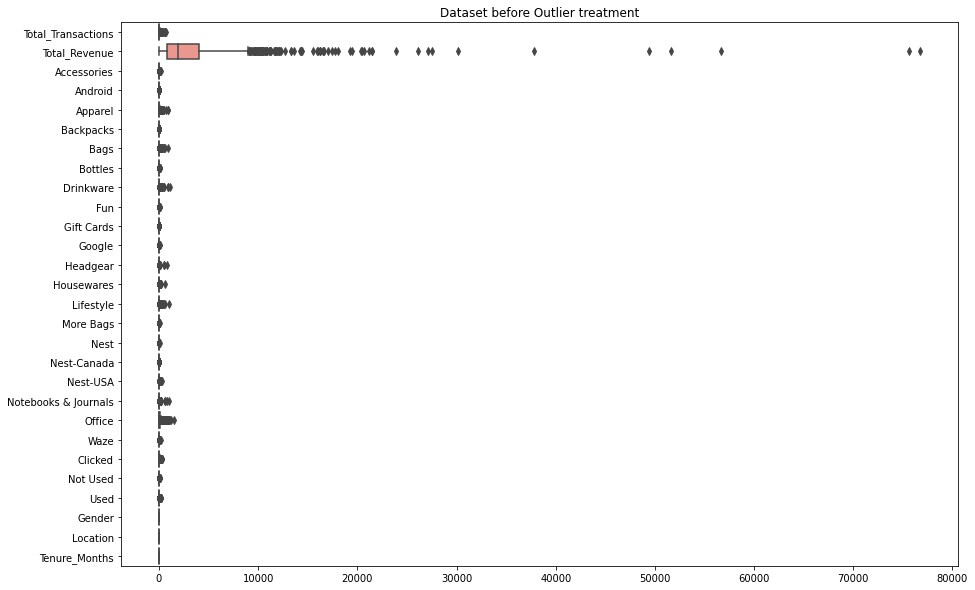

In [72]:
## Checking for outliers by Boxplot
plt.figure(figsize=(15,10))
sns.boxplot(data=A,orient="h")
plt.title("Dataset before Outlier treatment")
plt.show()

## Treating the outliers
A = treat_outliers(A)

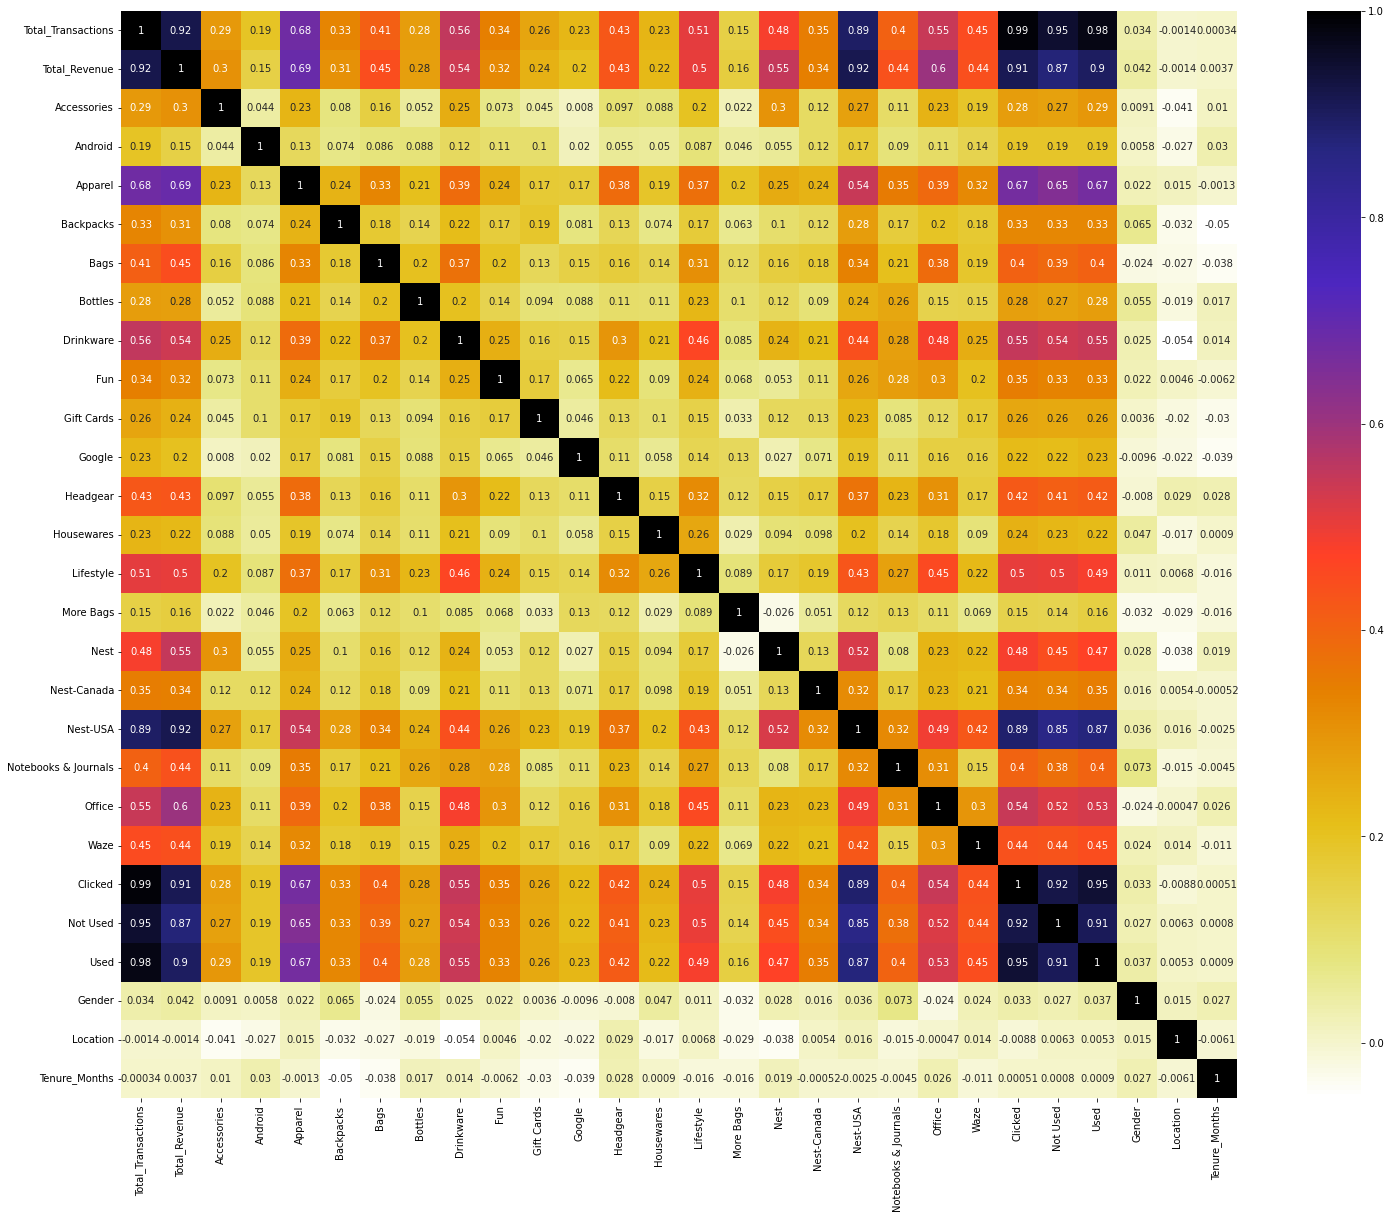

In [73]:
## Creating a correlation plot to check multicolinearity
plt.figure(figsize=(25,20))
sns.heatmap(data=A.corr(),annot=True, cmap=plt.cm.CMRmap_r)
plt.show()

In [74]:
highly_corr_col = ['Total_Transactions', 'Nest-USA', 'Clicked', 'Not Used', 'Used']
A = A.drop(Highly_corr_col,axis=1)

In [75]:
## Splitting the dataset into train & test
train_x, test_x, train_y, test_y = train_test_split(A, B, test_size=0.3, random_state=123)

print(f"train set: {train_x.shape, train_y.shape}")
print(f"test set: {test_x.shape, test_y.shape}")

train set: ((981, 23), (981,))
test set: ((421, 23), (421,))


In [76]:
## As we can see it is a imbalanced dataset
train_y.value_counts()

0-30 Days     970
30-60 Days      8
90+ Days        2
60-90 Days      1
Name: cust_segment, dtype: int64

In [77]:
# Initializing resampling technique RandomOverSampler
resampler = RandomOverSampler(random_state=42)
res_x_train, res_y_train = resampler.fit_resample(train_x, train_y)

In [78]:
res_y_train.value_counts()

0-30 Days     970
30-60 Days    970
60-90 Days    970
90+ Days      970
Name: cust_segment, dtype: int64

In [79]:
# Define the column names
numerical_cols = list(res_x_train.columns)


# Create the preprocessing steps for numerical columns
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')), ## imputing missing values if found any
    ('scaler', StandardScaler()) ## scalung up the data using standard scaler
])



# Create the column transformer
preprocessor_X = ColumnTransformer(transformers=[
    ('num', numerical_transformer, numerical_cols)
])



# Apply the preprocessing pipeline to Train_X and Test_X
sc_x_train = pd.DataFrame(preprocessor_X.fit_transform(res_x_train),columns=preprocessor_X.get_feature_names_out())
sc_x_test = pd.DataFrame(preprocessor_X.transform(test_x),columns=preprocessor_X.get_feature_names_out())

In [80]:
ord_encoder = OrdinalEncoder(categories=[['90+ Days', '60-90 Days', '30-60 Days', '0-30 Days']])

# Apply encoding to y_train_res and y_test
sc_y_train = ord_encoder.fit_transform(res_y_train.values.reshape(-1, 1)).ravel()
sc_y_test = ord_encoder.transform(test_y.values.reshape(-1, 1)).ravel()

#### Training & finding the best model for Next Purchase Day Prediction

In [81]:
result = evaluate_models(sc_x_train,sc_y_train,sc_x_test,sc_y_test,models)

# Print the results
for model_name, metrics in result.items():
    print(f"Model: {model_name}")
    print(f"Train Accuracy: {metrics['train_accuracy']:.4f}")
    print(f"Test Accuracy: {metrics['test_accuracy']:.4f}")
    print("Classification Report Train:")
    print(metrics['classification_report_train'])
    print("Classification Report Test:")
    print(metrics['classification_report_test'])
    print("=" * 50)

Model: Logistic Regression
Train Accuracy: 0.9552
Test Accuracy: 0.8266
Classification Report Train:
              precision    recall  f1-score   support

         0.0       0.96      1.00      0.98       970
         1.0       0.97      1.00      0.99       970
         2.0       0.90      1.00      0.95       970
         3.0       1.00      0.82      0.90       970

    accuracy                           0.96      3880
   macro avg       0.96      0.96      0.95      3880
weighted avg       0.96      0.96      0.95      3880

Classification Report Test:
              precision    recall  f1-score   support

         0.0       0.08      0.67      0.14         3
         1.0       0.00      0.00      0.00         0
         2.0       0.03      0.33      0.05         3
         3.0       1.00      0.83      0.91       415

    accuracy                           0.83       421
   macro avg       0.28      0.46      0.27       421
weighted avg       0.99      0.83      0.90       421

M

In [82]:
# Initializing Random Forest model
RF_class = RandomForestClassifier(random_state=42)

# Training the model
RF_class.fit(sc_x_train, sc_y_train)

# Predicting for Train & Test dataset
train_pred_RF = RF_class.predict(sc_x_train)
test_pred_RF = RF_class.predict(sc_x_test)

In [ ]:
## Setting up the path
path = "A:\Analytix\Machine learning\ML projects\Finding-Marketing-Insights\Cust_Nxt_purchase_Day_Model.pkl"

# saving best model into a picke file
with open(path, 'wb') as f:
    pickle.dump(RF_class, f)

### Market Basket Analysis

In [84]:
MBA_Data = cust_360

In [85]:
## This Function Clean the input DataFrame
def clean_data(df):
    df['Product_Description'] = df['Product_Description'].str.strip()
    df.dropna(axis=0, subset=['Transaction_ID'], inplace=True)
    df['Transaction_ID'] = df['Transaction_ID'].astype('str')
    return df


## This Function Create a basket of products for transaction data.
def create_basket(data, location=None):
    if location:
        basket = (data[data['Location'] == location]
                  .groupby(['Transaction_ID', 'Product_Description'])['Quantity']
                  .sum().unstack().reset_index().fillna(0)
                  .set_index('Transaction_ID'))
    else:
        basket = (data.groupby(['Transaction_ID', 'Product_Description'])['Quantity']
                  .sum().unstack().reset_index().fillna(0)
                  .set_index('Transaction_ID'))
    return basket

## This Function Encodes units based on a threshold.
def encode_units(x, threshold=0):
    return int(x >= threshold)

## This Function Generate association rules from transaction data using Apriori algorithm.
def generate_association_rules(data, metric="lift", min_support=0.003, min_confidence=0.1):
    frequent_itemsets = apriori(data, min_support=min_support, use_colnames=True)
    rules = association_rules(frequent_itemsets, metric=metric, min_threshold=1)
    filtered_rules = rules[(rules['lift'] >= 1) & (rules['confidence'] >= min_confidence)]
    return filtered_rules.sort_values(by='confidence', ascending=False)


In [86]:
MBA_Data_cleaned = clean_data(MBA_Data)

# Generate baskets for Chicago Location
chicago_basket = create_basket(MBA_Data_cleaned, location='Chicago')

# Encode units and apply Apriori
chicago_encoded = chicago_basket.applymap(lambda x: encode_units(x, threshold=1))

# Generate association rules for Chicago
chicago_association_rules = generate_association_rules(chicago_encoded)

print("Top 10 Product cobination for Chicago")
chicago_association_rules.head(10)

c:\Users\priya\AppData\Local\Programs\Python\Python310\lib\site-packages\mlxtend\frequent_patterns\fpcommon.py:110: DeprecationWarning:

DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type



Top 10 Product cobination for Chicago


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
0,(Android Sticker Sheet Ultra Removable),(Google Laptop and Cell Phone Stickers),0.008031,0.030693,0.003410,0.424658,13.835616,0.003164,1.684748,0.935233
29,(Nest Learning Thermostat 3rd Gen-USA - Stainl...,(Nest Cam Outdoor Security Camera - USA),0.008031,0.123652,0.003080,0.383562,3.101935,0.002087,1.421631,0.683107
28,(Nest Learning Thermostat 3rd Gen-USA - Stainl...,(Nest Cam Indoor Security Camera - USA),0.010011,0.118592,0.003080,0.307692,2.594548,0.001893,1.273145,0.620791
8,(Google Doodle Decal),(Google Laptop and Cell Phone Stickers),0.011661,0.030693,0.003520,0.301887,9.835666,0.003162,1.388467,0.908928
16,(YouTube Custom Decals),(Google Laptop and Cell Phone Stickers),0.017162,0.030693,0.004070,0.237179,7.727461,0.003544,1.270688,0.885793
12,(Maze Pen),(Google Laptop and Cell Phone Stickers),0.013861,0.030693,0.003080,0.222222,7.240143,0.002655,1.246252,0.873996
19,(Nest Cam Indoor Security Camera - USA),(Nest Cam Outdoor Security Camera - USA),0.118592,0.123652,0.023542,0.198516,1.605434,0.008878,1.093406,0.427856
7,(Sport Bag),(Google 22 oz Water Bottle),0.016612,0.024752,0.003190,0.192053,7.758940,0.002779,1.207069,0.885832
18,(Nest Cam Outdoor Security Camera - USA),(Nest Cam Indoor Security Camera - USA),0.123652,0.118592,0.023542,0.190391,1.605434,0.008878,1.088684,0.430327
15,(Sport Bag),(Google Laptop and Cell Phone Stickers),0.016612,0.030693,0.003080,0.185430,6.041444,0.002570,1.189962,0.848573


In [87]:
# Generate baskets for California Location
California_basket = create_basket(MBA_Data_cleaned, location='California')

# Encode units and apply Apriori
California_encoded = California_basket.applymap(lambda x: encode_units(x, threshold=1))

# Generate association rules for California
California_association_rules = generate_association_rules(California_encoded)

print("Top 10 Product cobination for California")
California_association_rules.head(10)


c:\Users\priya\AppData\Local\Programs\Python\Python310\lib\site-packages\mlxtend\frequent_patterns\fpcommon.py:110: DeprecationWarning:

DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type



Top 10 Product cobination for California


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
13,(Keyboard DOT Sticker),(Google Laptop and Cell Phone Stickers),0.007224,0.031305,0.003169,0.438596,14.010228,0.002942,1.725487,0.935381
10,(Google Doodle Decal),(Google Laptop and Cell Phone Stickers),0.012928,0.031305,0.004816,0.372549,11.900452,0.004412,1.543857,0.927966
9,(Sport Bag),(Google 22 oz Water Bottle),0.015970,0.027250,0.004816,0.301587,11.067553,0.004381,1.392802,0.924408
0,(8 pc Android Sticker Sheet),(Google Laptop and Cell Phone Stickers),0.010520,0.031305,0.003169,0.301205,9.621482,0.002839,1.386235,0.905592
7,(Recycled Paper Journal Set),(Google 22 oz Water Bottle),0.010139,0.027250,0.003042,0.300000,11.009302,0.002766,1.389643,0.918481
14,(YouTube Custom Decals),(Google Laptop and Cell Phone Stickers),0.016096,0.031305,0.004816,0.299213,9.557844,0.004312,1.382294,0.910022
16,(Google Men's Vintage Badge Tee White),(Google Men's Vintage Badge Tee Sage),0.010520,0.013815,0.003042,0.289157,20.930695,0.002896,1.387345,0.962347
19,(Windup Android),(Google Sunglasses),0.014449,0.028644,0.003422,0.236842,8.268514,0.003008,1.272812,0.891947
17,(Google Men's Vintage Badge Tee Sage),(Google Men's Vintage Badge Tee White),0.013815,0.010520,0.003042,0.220183,20.930695,0.002896,1.268863,0.965562
23,(Nest Cam Indoor Security Camera - USA),(Nest Cam Outdoor Security Camera - USA),0.120913,0.127376,0.023954,0.198113,1.555337,0.008553,1.088213,0.406162


In [88]:
# Generate baskets for New York Location
NY_basket = create_basket(MBA_Data_cleaned, location='New York')


# Encode units and apply Apriori
NY_encoded = NY_basket.applymap(lambda x: encode_units(x, threshold=1))

# Generate association rules for New York
NY_association_rules = generate_association_rules(NY_encoded)

print("Top 10 Product cobination for New York")
NY_association_rules.head(10)


c:\Users\priya\AppData\Local\Programs\Python\Python310\lib\site-packages\mlxtend\frequent_patterns\fpcommon.py:110: DeprecationWarning:

DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type



Top 10 Product cobination for New York


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
4,(Android Sticker Sheet Ultra Removable),(Google Laptop and Cell Phone Stickers),0.010002,0.032006,0.004546,0.454545,14.201963,0.004226,1.774656,0.938979
21,(Google Women's Scoop Neck Tee White),(Google Women's Scoop Neck Tee Black),0.007274,0.007456,0.003091,0.425000,57.001829,0.003037,1.726164,0.989656
20,(Google Women's Scoop Neck Tee Black),(Google Women's Scoop Neck Tee White),0.007456,0.007274,0.003091,0.414634,57.001829,0.003037,1.695907,0.989837
10,(Google Doodle Decal),(Google Laptop and Cell Phone Stickers),0.012002,0.032006,0.004728,0.393939,12.308368,0.004344,1.597190,0.929915
1,(Android Sticker Sheet Ultra Removable),(8 pc Android Sticker Sheet),0.010002,0.010911,0.003819,0.381818,34.993636,0.003710,1.599997,0.981238
2,(8 pc Android Sticker Sheet),(Google Laptop and Cell Phone Stickers),0.010911,0.032006,0.004001,0.366667,11.456250,0.003652,1.528412,0.922780
0,(8 pc Android Sticker Sheet),(Android Sticker Sheet Ultra Removable),0.010911,0.010002,0.003819,0.350000,34.993636,0.003710,1.523074,0.982140
37,(Nest Learning Thermostat 3rd Gen-USA - Stainl...,(Nest Cam Outdoor Security Camera - USA),0.009274,0.133843,0.003091,0.333333,2.490489,0.001850,1.299236,0.604075
16,(YouTube Custom Decals),(Google Laptop and Cell Phone Stickers),0.014366,0.032006,0.004728,0.329114,10.282940,0.004268,1.442859,0.915910
36,(Nest Learning Thermostat 3rd Gen-USA - Stainl...,(Nest Cam Indoor Security Camera - USA),0.011275,0.127478,0.003091,0.274194,2.150913,0.001654,1.202142,0.541183


In [89]:
# Generate baskets for New Jersey Location
NJ_basket = create_basket(MBA_Data_cleaned, location='New Jersey')

# Encode units and apply Apriori
NJ_encoded = NJ_basket.applymap(lambda x: encode_units(x, threshold=1))

# Generate association rules for New Jersey
NJ_association_rules = generate_association_rules(NJ_encoded)

print("Top 10 Product cobination for New Jersey")
NJ_association_rules.head(10)

Top 10 Product cobination for New Jersey


c:\Users\priya\AppData\Local\Programs\Python\Python310\lib\site-packages\mlxtend\frequent_patterns\fpcommon.py:110: DeprecationWarning:

DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type



,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
1,(22 oz Android Bottle),(Google 22 oz Water Bottle),0.006611,0.035258,0.004848,0.733333,20.799167,0.004615,3.617783,0.958256
7,(Pen Pencil & Highlighter Set),(Four Color Retractable Pen),0.004848,0.014544,0.003085,0.636364,43.754821,0.003015,2.710004,0.981906
22,(Google Doodle Decal),(Google Laptop and Cell Phone Stickers),0.011900,0.028647,0.004848,0.407407,14.221652,0.004507,1.639158,0.940881
11,(Google Kick Ball),(Google 22 oz Water Bottle),0.009696,0.035258,0.003526,0.363636,10.313636,0.003184,1.516023,0.911883
3,(Google Metallic Notebook Set),(Four Color Retractable Pen),0.011018,0.014544,0.003967,0.360000,24.752727,0.003806,1.539775,0.970291
47,(Nest Learning Thermostat 3rd Gen-USA - Stainl...,(Nest Cam Outdoor Security Camera - USA),0.011018,0.116351,0.003967,0.360000,3.094091,0.002685,1.380702,0.684343
24,(YouTube Custom Decals),(Google Laptop and Cell Phone Stickers),0.014985,0.028647,0.005289,0.352941,12.320362,0.004859,1.501182,0.932811
13,(Google Metallic Notebook Set),(Google 22 oz Water Bottle),0.011018,0.035258,0.003526,0.320000,9.076000,0.003137,1.418738,0.899733
27,(Google Men's 100% Cotton Short Sleeve Hero Te...,(Google Men's 100% Cotton Short Sleeve Hero Te...,0.015425,0.026884,0.004848,0.314286,11.690398,0.004433,1.419127,0.928787
46,(Nest Learning Thermostat 3rd Gen-USA - Stainl...,(Nest Cam Indoor Security Camera - USA),0.012781,0.133098,0.003967,0.310345,2.331697,0.002265,1.257007,0.578522


In [90]:
# Generate baskets for Washington DC Location
WDC_basket = create_basket(MBA_Data_cleaned, location='Washington DC')

# Encode units and apply Apriori
WDC_encoded = WDC_basket.applymap(lambda x: encode_units(x, threshold=1))

# Generate association rules for Washington DC
WDC_association_rules = generate_association_rules(WDC_encoded)

print("Top 10 Product cobination for Washington DC")
WDC_association_rules.head(10)

Top 10 Product cobination for Washington DC


c:\Users\priya\AppData\Local\Programs\Python\Python310\lib\site-packages\mlxtend\frequent_patterns\fpcommon.py:110: DeprecationWarning:

DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type



,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
35,(Nest Protect Smoke + CO White Battery Alarm-U...,(Nest Cam Outdoor Security Camera - USA),0.004965,0.141135,0.003546,0.714286,5.061019,0.002845,3.006028,0.806415
2,(Android Sticker Sheet Ultra Removable),(Google Laptop and Cell Phone Stickers),0.008511,0.027660,0.004965,0.583333,21.089744,0.004729,2.333617,0.960760
0,(8 pc Android Sticker Sheet),(Google Laptop and Cell Phone Stickers),0.009220,0.027660,0.004965,0.538462,19.467456,0.004710,2.106738,0.957460
10,(Google Doodle Decal),(Google Laptop and Cell Phone Stickers),0.013475,0.027660,0.007092,0.526316,19.028340,0.006719,2.052719,0.960388
19,(Google Men's Vintage Badge Tee White),(Google Men's Vintage Badge Tee Black),0.009929,0.019149,0.004255,0.428571,22.380952,0.004065,1.716489,0.964900
34,(Nest Protect Smoke + CO White Battery Alarm-U...,(Nest Cam Indoor Security Camera - USA),0.009220,0.138298,0.003546,0.384615,2.781065,0.002271,1.400266,0.646385
14,(YouTube Custom Decals),(Google Laptop and Cell Phone Stickers),0.016312,0.027660,0.005674,0.347826,12.575251,0.005223,1.490922,0.935743
4,(Four Color Retractable Pen),(Ballpoint LED Light Pen),0.012766,0.012766,0.004255,0.333333,26.111111,0.004092,1.480851,0.974138
5,(Ballpoint LED Light Pen),(Four Color Retractable Pen),0.012766,0.012766,0.004255,0.333333,26.111111,0.004092,1.480851,0.974138
23,(Google Women's Short Sleeve Badge Tee Grey),(Google Women's Short Sleeve Hero Tee Grey),0.010638,0.014894,0.003546,0.333333,22.380952,0.003388,1.477660,0.965591


### Cohort Analysis

In [91]:
coh_data = cust_360

In [ ]:
# Create a Transaction_month column
coh_data['Transaction_month'] = coh_data['Transaction_Date'].apply(lambda x: x.strftime('%Y-%m'))

# Set CustomerID as the index
coh_data.set_index('CustomerID', inplace=True)

# Calculate the CohortGroup for each customer
coh_data['CohortGroup'] = coh_data.groupby(level=0)['Transaction_Date'].min().apply(lambda x: x.strftime('%Y-%m'))
coh_data.reset_index(inplace=True)

# Group data by CohortGroup and Transaction_month
datagrouped = coh_data.groupby(['CohortGroup', 'Transaction_month'])

# Aggregate cohorts data
cohorts = datagrouped.agg({'CustomerID': pd.Series.nunique,
                           'Transaction_ID': pd.Series.nunique,
                           'Invoice_Amount': pd.Series.sum})

# Rename columns
cohorts.rename(columns={'CustomerID': 'Total_Users',
                        'Transaction_ID': 'Total_orders',
                        'Invoice_Amount': 'Revenue'}, inplace=True)

# Define cohort_period function
def cohort_period(df):
    df['CohortPeriod'] = np.arange(len(df)) + 1
    return df

# Apply cohort_period function
cohorts = cohorts.groupby(level=0).apply(cohort_period)

# Reset index and set multi-index for CohortGroup and CohortPeriod
cohorts.reset_index(inplace=True)
cohorts.set_index(['CohortGroup', 'CohortPeriod'], inplace=True)

# Calculate cohort group size
cohort_group_size = cohorts['Total_Users'].groupby(level=0).first()

# Calculate customer retention rates
cust_retention = cohorts['Total_Users'].unstack(0).divide(cohort_group_size, axis=1)

data = pd.DataFrame(cohorts)

# Convert the multi-index columns to normal columns
data.columns = data.columns.to_flat_index()

# Reset the index to make it a normal DataFrame
data.reset_index(inplace=True)


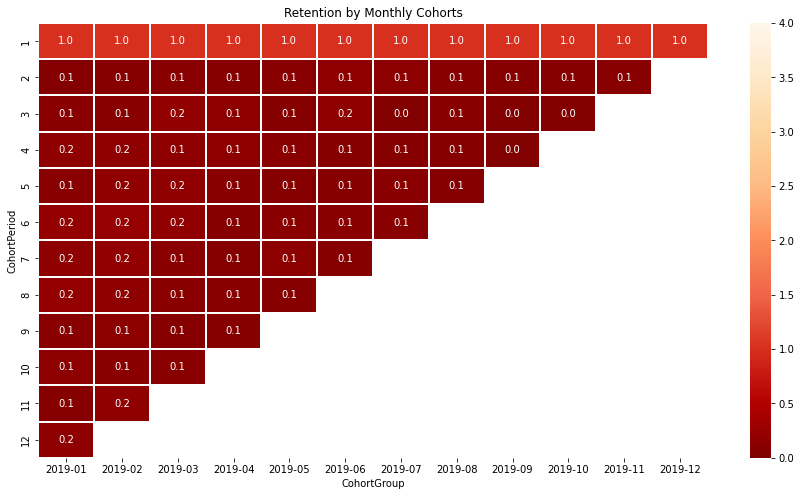

In [152]:
# Plot the retention heatmap
plt.figure(figsize=(15, 8))
plt.title('Retention by Monthly Cohorts')
sns.heatmap(data=cust_retention,
            annot=True,
            cmap="OrRd_r",
            vmin=0.0,
            vmax=list(cust_retention.max().sort_values(ascending=False))[1] + 3,
            fmt='.1f',
            linewidth=0.3)
plt.savefig("Retention By Monthly Cohorts")
plt.show()

# Create a subplot with 3 rows and 1 column
fig = sp.make_subplots(rows=3, cols=1,
                       subplot_titles=("Total Users by Cohort Period", "Total Orders by Cohort Period", "Total Revenue by Cohort Period"))

# Add Line Plot for Total Users
fig1 = px.line(data,
               x='CohortPeriod',
               y='Total_Users',
               color='CohortGroup',
               labels=dict(CohortPeriod="Cohort Period", Total_Users="Total Users"),
               title="Total Users by Cohort Period",
               template="plotly_dark")
fig.add_trace(go.Scatter(fig1['data'][0]), row=1, col=1)
for i in range(1, len(fig1['data'])):
    fig.add_trace(go.Scatter(fig1['data'][i]), row=1, col=1)

# Add Bar Plot for Total Orders
fig2 = px.bar(data,
              x='CohortPeriod',
              y='Total_orders',
              color='CohortGroup',
              labels=dict(CohortPeriod="Cohort Period", Total_orders="Total Orders"),
              title="Total Orders by Cohort Period",
              template="plotly_dark")
fig.add_trace(go.Bar(fig2['data'][0]), row=2, col=1)
for i in range(1, len(fig2['data'])):
    fig.add_trace(go.Bar(fig2['data'][i]), row=2, col=1)

# Add Line Plot for Total Revenue
fig3 = px.line(data,
               x='CohortPeriod',
               y='Revenue',
               color='CohortGroup',
               labels=dict(CohortPeriod="Cohort Period", Revenue="Total Revenue"),
               title="Total Revenue by Cohort Period",
               template="plotly_dark")
fig.add_trace(go.Scatter(fig3['data'][0]), row=3, col=1)
for i in range(1, len(fig3['data'])):
    fig.add_trace(go.Scatter(fig3['data'][i]), row=3, col=1)

# Update layout and display the plot
fig.update_layout(
    height=1000, width=1200, 
    showlegend=False,
    template="plotly_dark"
)
fig.show()